# 4d. Evaluate predictions with special categories

In the previous notebook I demonstrated how we evaluate the models used at UCLH. As a final step, I now show the same implementation in code, but including extra functionality to handle certain sub-groups differently from others. 

At UCLH, it is standard practice to admit paediatric patients (defined as patients under 18 on the day of arrival at the ED) to paediatric wards, and not to admit adult patients (18 or over) to paediatric wards. 

In the two models that enable prediction by sub-groups, offer parameters that allwo you to specify that certain groups are handled differently. In the UCLH example, this means disregarding any consult requests when predicting which specialty they will be admitted to, and counting all yet-to-arrive patients under 18 as paediatric admissions. 

Most of the code below is the same as in the previous notebook. I limit the narrative here to pointing out how the special sub-groups are handled. 

## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from patientflow.load import set_project_root
project_root = set_project_root()


Inferred project root: /Users/zellaking/Repos/patientflow


## Set file paths and load data

I'm going to use real patient data from UCLH to demonstrate the implementation. 

As noted previously, you can request the datasets that are used here on [Zenodo](https://zenodo.org/records/14866057). Alternatively you can use the synthetic data that has been created from the distributions of real patient data. If you don't have the public data, change the argument in the cell below from `data_folder_name='data-public'` to `data_folder_name='data-synthetic'`.

In [3]:
from patientflow.load import set_file_paths

# set file paths
data_folder_name = 'data-public'
data_file_path = project_root / data_folder_name

data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
    project_root, 
    data_folder_name=data_folder_name,
    config_file = 'config.yaml', verbose=False)

In [4]:
import pandas as pd
from patientflow.load import load_data

# load ED snapshots data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])
ed_visits.snapshot_date = pd.to_datetime(ed_visits.snapshot_date).dt.date

# load data on inpatient arrivals
inpatient_arrivals = inpatient_arrivals = load_data(data_file_path, 
                    file_name='inpatient_arrivals.csv')
inpatient_arrivals['arrival_datetime'] = pd.to_datetime(inpatient_arrivals['arrival_datetime'], utc = True)


## Set modelling parameters

The parameters are used in training or inference. They are set in config.json in the root of the repository and loaded by `load_config_file()`

In [5]:
# load params
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]


## Apply temporal splits

In [6]:
from patientflow.prepare import create_temporal_splits

train_visits_df, valid_visits_df, test_visits_df = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date",
)

train_inpatient_arrivals_df, _, test_inpatient_arrivals_df = create_temporal_splits(
    inpatient_arrivals,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="arrival_datetime",
)

Split sizes: [62071, 10415, 29134]
Split sizes: [7716, 1285, 3898]


## Train models to predict bed count distributions for patients currently in the ED

This time I'll use a larger parameter grid, while still limiting the search space to a few hyperparameters for expediency.

In [7]:

from patientflow.train.classifiers import train_classifier
from patientflow.load import get_model_key

grid = { # Current parameters
    'n_estimators': [30, 40, 50],  # Number of trees
    'subsample': [0.7, 0.8, 0.9],  # Sample ratio of training instances
    'colsample_bytree': [0.7, 0.8, 0.9],  # Sample ratio of columns for each tree
   } 

exclude_from_training_data = [ 'snapshot_date', 'prediction_time','visit_number', 'consultation_sequence', 'specialty', 'final_sequence', ]

ordinal_mappings = {
    "latest_acvpu": ["A", "C", "V", "P", "U"],
    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],
    "latest_obs_objective_pain_score": [
        "Nil",
        "Mild",
        "Moderate",
        "Severe\\E\\Very Severe",
    ],
    "latest_obs_level_of_consciousness": ["A", "C", "V", "P", "U"],
}

# create a dictionary to store the trained models
admissions_models = {}
model_name = 'admissions'

# Loop through each prediction time
for prediction_time in ed_visits.prediction_time.unique():
    print(f"Training model for {prediction_time}")
    model = train_classifier(
        train_visits=train_visits_df,
        valid_visits=valid_visits_df,
        test_visits=test_visits_df,
        grid=grid,
        exclude_from_training_data=exclude_from_training_data,
        ordinal_mappings=ordinal_mappings,
        prediction_time=prediction_time,
        visit_col="visit_number",
        calibrate_probabilities=True,
        calibration_method="isotonic",
        use_balanced_training=True,
    )
    model_key = get_model_key(model_name, prediction_time)
    
    admissions_models[model_key] = model

Training model for (22, 0)
Training model for (15, 30)
Training model for (6, 0)
Training model for (12, 0)
Training model for (9, 30)


## Train specialty model

Here, when training the model predicting specialty of admission, the `apply_special_category_filtering` parameter has been set to True, so it will be assumed that all patients under 18 on arrival will be admitted to a paediatric specialty. 

In [8]:
from patientflow.predictors.sequence_predictor import SequencePredictor

spec_model = SequencePredictor(
    input_var="consultation_sequence",
    grouping_var="final_sequence",
    outcome_var="specialty",
    apply_special_category_filtering=True,
)

spec_model = spec_model.fit(train_visits_df)

spec_model

SequencePredictor(
    input_var='consultation_sequence',
    grouping_var='final_sequence',
    outcome_var='specialty',
    apply_special_category_filtering=True,
    admit_col='is_admitted'
)

Under the hood, the `SequencePredictor` will call a `create_special_category_objects()` function that returns rules for how to handle each subgroup. The implementation here is primarily designed to handle pediatric patients (under 18) as a special category. A `SpecialCategoryParams` class generates a dictionary mapping specialties to flags (1.0 for pediatric, 0.0 for others) and functions to identify pediatric patients based on age data. It provides methods to handle both age formats (age_on_arrival or age_group). 

The `SequencePredictor` applies these rules during both training and prediction, ensuring consistent handling of special categories across the entire prediction pipeline

The `SpecialCategoryParams` class is designed to be picklable, which is necessary for saving the specialty predictor model to disk.

The output from `create_special_category_objects` is shown below. Note that the output is specific to the UCLH implementation. See below for notes about how to change this for your implementation. 

In [ ]:
from patientflow.prepare import create_special_category_objects
create_special_category_objects(train_visits_df.columns)

{'special_category_func': <bound method SpecialCategoryParams.special_category_func of <patientflow.prepare.SpecialCategoryParams object at 0x1208774d0>>,
 'special_category_dict': {'medical': 0.0,
  'surgical': 0.0,
  'haem/onc': 0.0,
  'paediatric': 1.0},
 'special_func_map': {'paediatric': <bound method SpecialCategoryParams.special_category_func of <patientflow.prepare.SpecialCategoryParams object at 0x1208774d0>>,
  'default': <bound method SpecialCategoryParams.opposite_special_category_func of <patientflow.prepare.SpecialCategoryParams object at 0x1208774d0>>}}

If a model has been trained with special parameters, they will be saved within the model object. 

In [15]:
spec_model.special_params

{'special_category_func': <bound method SpecialCategoryParams.special_category_func of <patientflow.prepare.SpecialCategoryParams object at 0x2903263c0>>,
 'special_category_dict': {'medical': 0.0,
  'surgical': 0.0,
  'haem/onc': 0.0,
  'paediatric': 1.0},
 'special_func_map': {'paediatric': <bound method SpecialCategoryParams.special_category_func of <patientflow.prepare.SpecialCategoryParams object at 0x2903263c0>>,
  'default': <bound method SpecialCategoryParams.opposite_special_category_func of <patientflow.prepare.SpecialCategoryParams object at 0x2903263c0>>}}

## Train models for yet-to-arrive patients

Predictions for patients who are yet-to-arrive models are based on arrival rates learned from past data. See  [3c_Predict_bed_counts_without_using_patient_snapshots.ipynb](3c_Predict_bed_counts_without_using_patient_snapshots.ipynb.) for more information. When making predictions by specialty, arrival rates are learned for each specialty separately. 

The `create_yta_filters()` function generates a dictionary of filters for the `WeightedPoissonPredictor` to enable separate prediction models for each specialty. It uses the same special category configuration (as defined in `create_special_category_objects`) to create two types of filters:

* For pediatric patients: {"is_child": True}
* For other specialties: {"specialty": specialty_name, "is_child": False}

This allows the predictor to 
* Train separate models for each specialty
* Handle sub-groups differently
* Apply appropriate filtering during both training and prediction



In [13]:
from patientflow.predictors.weighted_poisson_predictor import WeightedPoissonPredictor
from patientflow.prepare import create_yta_filters

x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]
prediction_window = params["prediction_window"]
yta_time_interval = params["yta_time_interval"]

specialty_filters = create_yta_filters(ed_visits)
yta_model_by_spec =  WeightedPoissonPredictor(filters = specialty_filters, verbose=False)

# calculate the number of days between the start of the training and validation sets; used for working out daily arrival rates
num_days = (start_validation_set - start_training_set).days

if 'arrival_datetime' in train_inpatient_arrivals_df.columns:
    train_inpatient_arrivals_df.set_index('arrival_datetime', inplace=True)

yta_model_by_spec =yta_model_by_spec.fit(train_inpatient_arrivals_df, 
              prediction_window=prediction_window, 
              yta_time_interval=yta_time_interval, 
              prediction_times=ed_visits.prediction_time.unique(), 
              num_days=num_days )

The special parameters are not saved with the WeightedPoissonPredictor because they are only used once during initialization to create static filters that map specialties to their configurations (e.g., {'is_child': True} for pediatric cases). These filters, which are derived from the special parameters, are sufficient for the WeightedPoissonPredictor's purpose of making yet-to-arrive predictions by specialty. 

In contrast, the SequencePredictor needs to save the special parameters because it actively uses them during both training and prediction to filter and categorize patients based on their characteristics.

## Changes required in your implementation

Listed below are the functions that relate to this special handling. 

1. **SpecialCategoryParams Class** (`src/patientflow/prepare.py`):
- Specialty names and flags in `special_category_dict`
- Age detection logic in `special_category_func`
- Category mapping in `special_func_map`

2. **SequencePredictor Class** (`src/patientflow/predictors/sequence_predictor.py`):
- Uses `create_special_category_objects` in `_preprocess_data`
- Filters data based on special categories
- Handles specialty predictions differently for special categories

3. **SingleInputPredictor Class** (`src/patientflow/predictors/single_input_predictor.py`):
- Similar to SequencePredictor, uses special category filtering
- Applies the same filtering logic in `_preprocess_data`

4. **create_yta_filters Function** (`src/patientflow/prepare.py`):
- Creates specialty filters based on special category parameters
- Generates filter configurations for each specialty

5. **get_specialty_probs Function** (`src/patientflow/predict/emergency_demand.py`):
- Uses special category functions to determine specialty probabilities
- Applies different probability distributions for special categories

6. **create_predictions Function** (`src/patientflow/predict/emergency_demand.py`):
- Validates that requested specialties match special category dictionary
- Uses special function map for filtering predictions
- Applies different prediction logic for special categories

7. **WeightedPoissonPredictor Class** (`src/patientflow/predictors/weighted_poisson_predictor.py`):
- Uses specialty filters for predictions
- Handles different prediction logic for special categories

8. **Tests** (`tests/test_create_predictions.py`):
- Test cases for special category handling
- Validation of special category predictions

To modify your implementation for different specialty names and rules, you would need to:

1. Create a new class that inherits from `SpecialCategoryParams` with your custom logic
2. Update all the specialty names and flags in the special category dictionary
3. Modify the detection functions for your special categories
4. Update the filter configurations in `create_yta_filters`
5. Ensure all test cases are updated to reflect your new specialty structure
6. Update any documentation or examples that reference the specialty names


## Generate predicted distributions for each specialty and prediction time for patients in ED

Now that the models have been trained with the special parameters, we proceed with generating and evaluating predictions. The approach below uses a similar function to the `get_specialty_probability_distributions` function shown in the previous notebook, with some additional logic to identify sub-groups that need special processing. 

The function 

* retrieves the special parameters than were saved with the specialty predictor
* ensures that only eligible patient snapshots are included in the predictions for each specialty. A temporary version of the test set, called `test_df_eligible` is created for each iteration through the various specialties using only the eligible visits 

Why is this necessary? Imagine an ED that currently has 75 adult patients and 25 children. Tje maximum number of beds that could be needed in the paediatric specialties is 25 and the maximum number of beds that could be needed in the adult specialties is 75. Without filtering a probabilty distribution for 100 beds would be produced. The logic below means that adult patients are excluded from the predicted distribution for the paediatric specialty, and children from the predicted distributions for the adult specialty. 



In [18]:
from patientflow.prepare import prepare_patient_snapshots, prepare_group_snapshot_dict
from patientflow.aggregate import get_prob_dist
from patientflow.predict.emergency_demand import get_specialty_probs
from patientflow.load import get_model_key


def get_specialty_probability_distributions_with_special_categories(
    test_visits_df,
    spec_model,
    admissions_models,
    model_name,
    exclude_from_training_data,
    specialties=['medical', 'surgical', 'haem/onc', 'paediatric'],
    baseline_prob_dict=None,
):
    """
    Calculate probability distributions for emergency department patients by specialty and prediction time.
    
    Args:
        test_visits_df: DataFrame containing test visit data
        spec_model: Model for specialty predictions (SequencePredictor)
        admissions_models: Dictionary of admission prediction models
        model_name: Name of the model to use
        specialties: List of specialties to consider
        exclude_from_training_data: List of columns to exclude from training data
        baseline_prob_dict: Optional dict of baseline probabilities to use instead of spec_model predictions
        
    Returns:
        Dictionary containing probability distributions for each specialty and prediction time
    """
    # Get specialty prediction parameters
    special_params = spec_model.special_params
    special_category_func = special_params["special_category_func"]
    special_category_dict = special_params["special_category_dict"]
    special_func_map = special_params["special_func_map"]

    # Get predictions of admission to specialty
    if baseline_prob_dict is not None:
        # Use baseline probabilities instead of model predictions
        # Create paediatric dictionary for age group 0-17
        paediatric_dict = {key: 0 for key in baseline_prob_dict.keys()}
        paediatric_dict['paediatric'] = 1
        
        # Apply different dictionaries based specialty category function
        test_visits_df.loc[:, "specialty_prob"] = test_visits_df.apply(
            lambda row: paediatric_dict if special_category_func(row) else baseline_prob_dict,
            axis=1
        )
    else:
        # Use spec_model to get predictions
        test_visits_df.loc[:, "specialty_prob"] = get_specialty_probs(
            specialties,
            spec_model,
            test_visits_df,
            special_category_func=special_category_func,
            special_category_dict=special_category_dict,
        )

    # Initialize dictionary to store probability distributions
    prob_dist_dict_all = {}

    # Process each time of day
    for _prediction_time in test_visits_df.prediction_time.unique():
        prob_dist_dict_for_pats_in_ED = {}
        print("\nProcessing :" + str(_prediction_time))
        model_key = get_model_key(model_name, _prediction_time)
        
        for specialty in specialties:
            print(f"Predicting bed counts for {specialty} specialty, for all snapshots in the test set")
            
            # Get indices of patients who are eligible for this specialty
            func = special_func_map.get(specialty, special_func_map["default"])
            non_zero_indices = test_visits_df[
                test_visits_df.apply(func, axis=1)
            ].index

            test_df_eligible = test_visits_df.copy()
            test_df_eligible = test_df_eligible.loc[non_zero_indices]

            # Get probability of admission to specialty for eligible patients
            prob_admission_to_specialty = test_df_eligible["specialty_prob"].apply(
                lambda x: x[specialty]
            )
            
            # Prepare patient snapshots
            X_test, y_test = prepare_patient_snapshots(
                df=test_df_eligible, 
                prediction_time=_prediction_time, 
                single_snapshot_per_visit=False,
                exclude_columns=exclude_from_training_data, 
                visit_col='visit_number'
            )

            # Filter probabilities for eligible patients
            filtered_prob_admission_to_specialty = prob_admission_to_specialty.loc[
                non_zero_indices
            ]

            # Prepare group snapshots
            group_snapshots_dict = prepare_group_snapshot_dict(
                test_df_eligible[test_df_eligible.prediction_time == _prediction_time]
            )

            admitted_to_specialty = test_df_eligible['specialty'] == specialty

            # Get probability distribution for this time and specialty
            prob_dist_dict_for_pats_in_ED[specialty] = get_prob_dist(
                group_snapshots_dict, X_test, y_test, admissions_models[model_key], 
                weights=filtered_prob_admission_to_specialty,
                category_filter=admitted_to_specialty, 
                normal_approx_threshold=30
            )

        prob_dist_dict_all[f'{model_key}'] = prob_dist_dict_for_pats_in_ED

    return prob_dist_dict_all

In [ ]:
prob_dist_dict_all = get_specialty_probability_distributions_with_special_categories(
    test_visits_df=test_visits_df,
    spec_model=spec_model,      
    admissions_models=admissions_models,
    model_name=model_name,
    exclude_from_training_data=exclude_from_training_data,
)


Processing :(22, 0)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all snapshots in the test set

Processing :(6, 0)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all snapshots in the test set

Processing :(15, 30)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all 

## Visualise the performance of emergency demand prediction models for patients in the ED

Below I show various ways to evaluate the predicted distributions. 
* histograms of observed versus expected values
* Adjusted QQ plots

See [a previous notebook](3b_Evaluate_group_snapshots.ipynb) for more on these approaches.


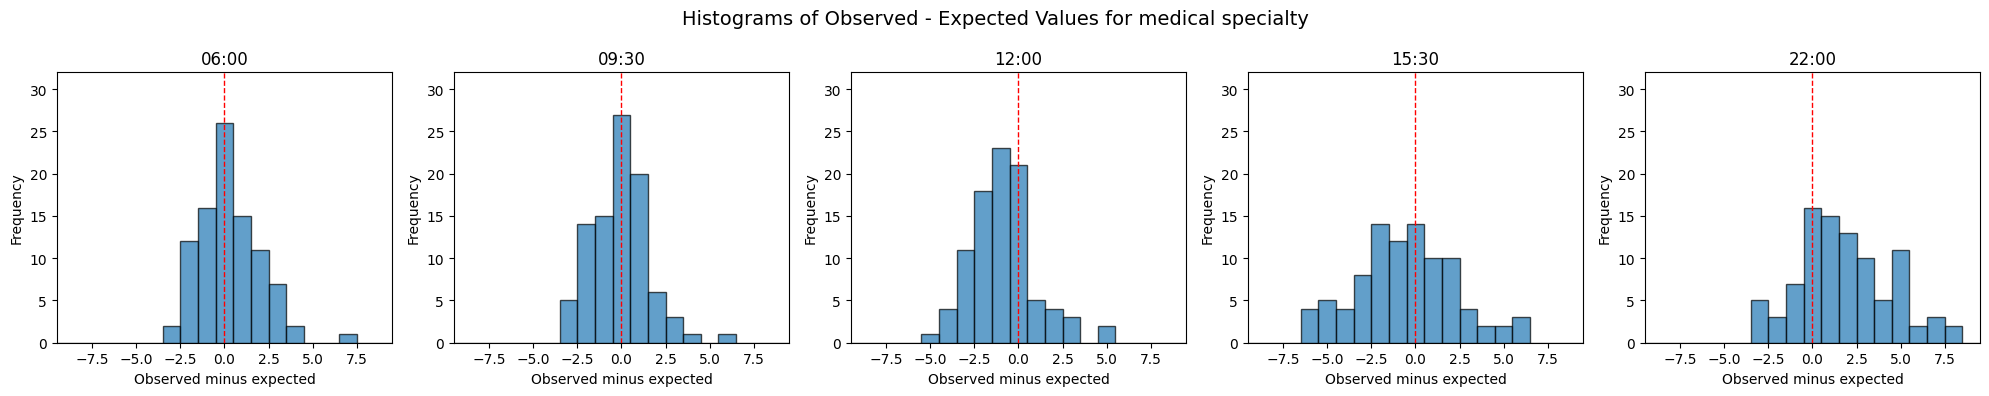

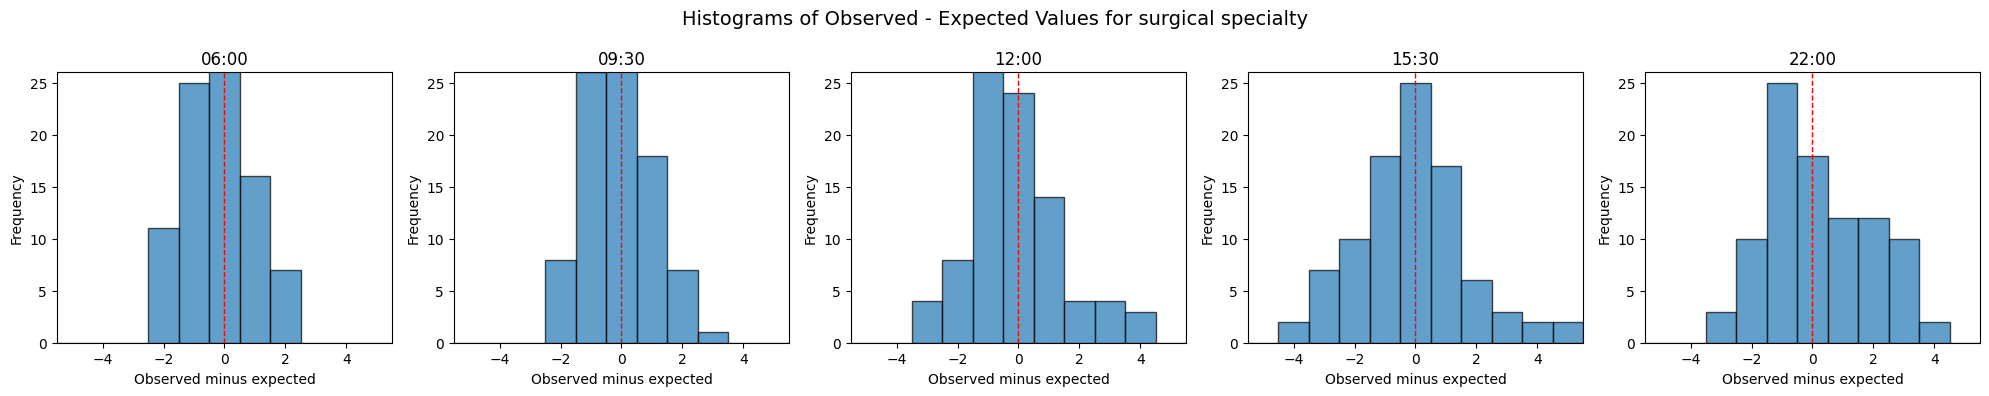

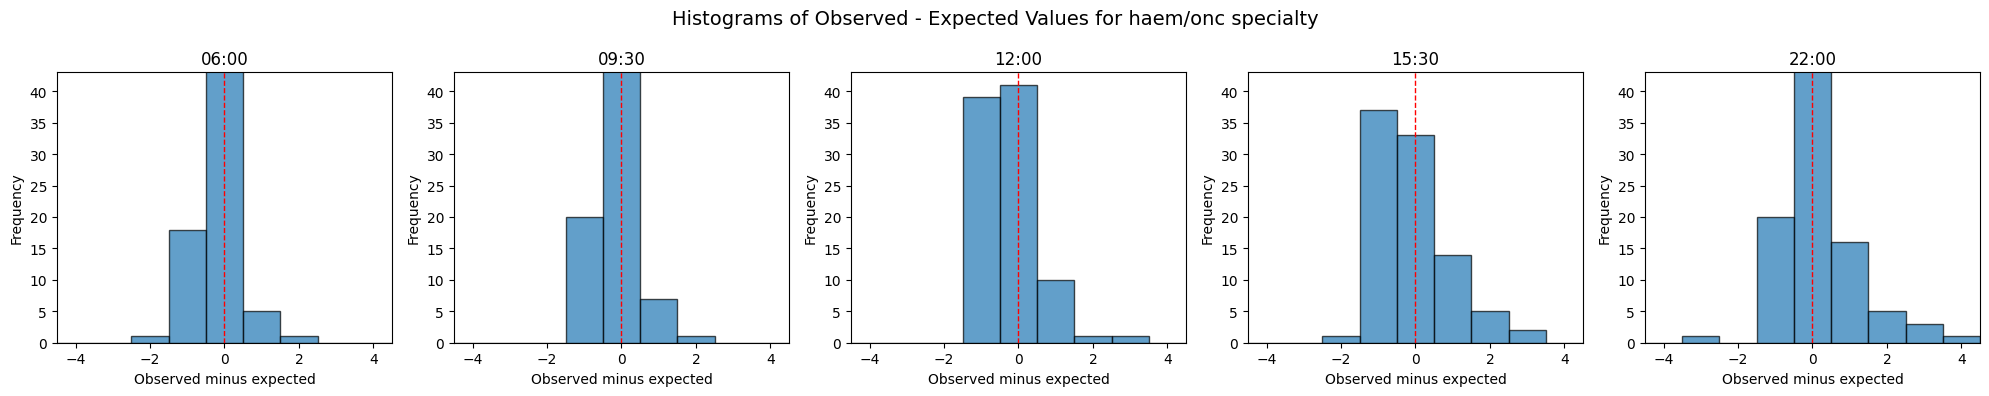

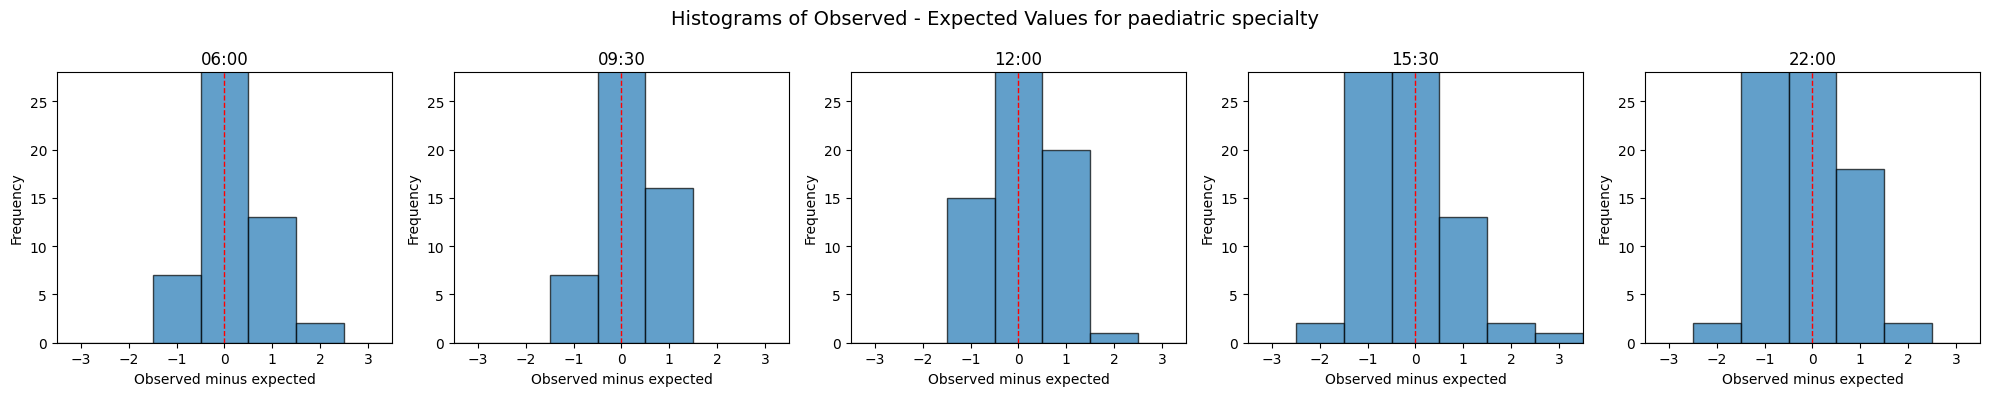

In [11]:
from patientflow.evaluate import calc_mae_mpe
from patientflow.viz.evaluation_plots import plot_observed_against_expected
specialties=['medical', 'surgical', 'haem/onc', 'paediatric']

for specialty in specialties:

    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all.items()}
    results = calc_mae_mpe(specialty_prob_dist)
    plot_observed_against_expected(results, 
                                   main_title=f"Histograms of Observed - Expected Values for {specialty} specialty",)


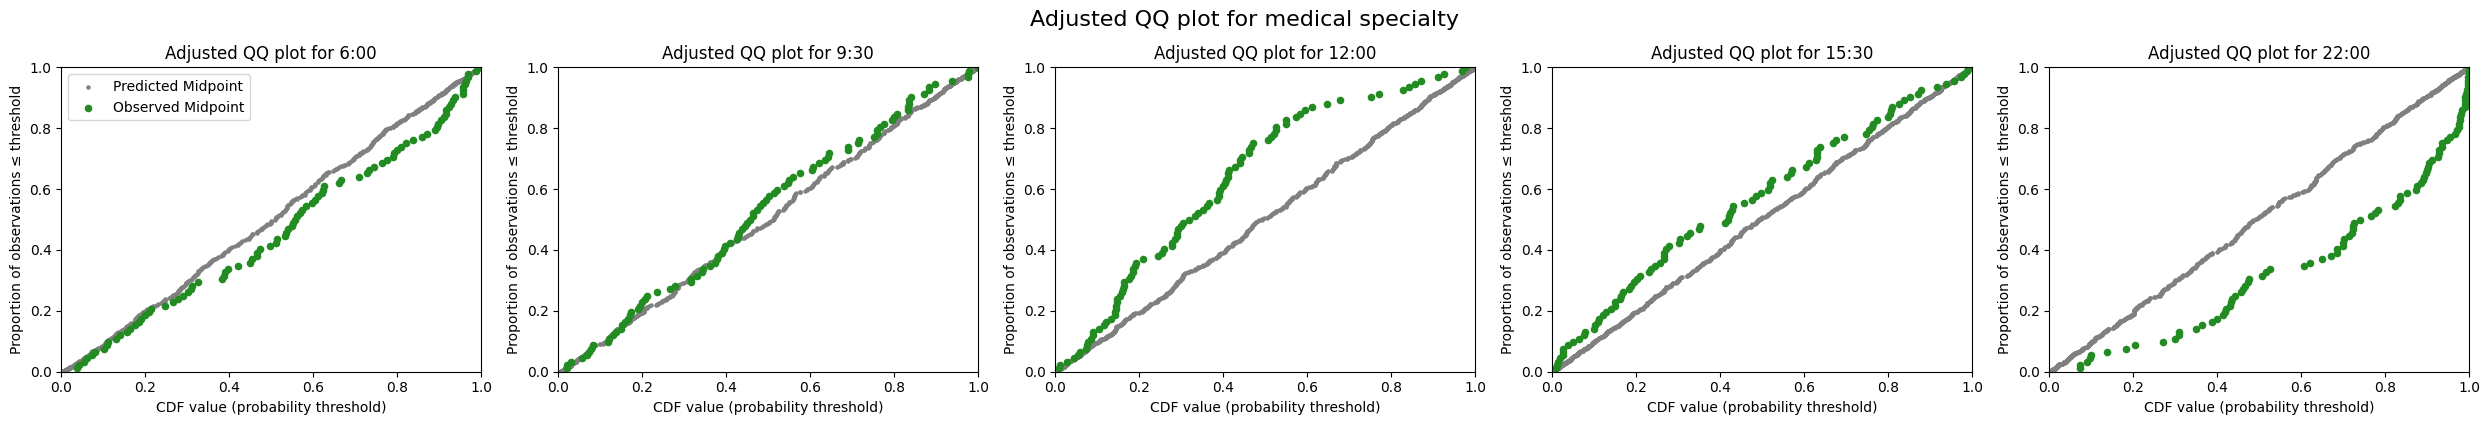

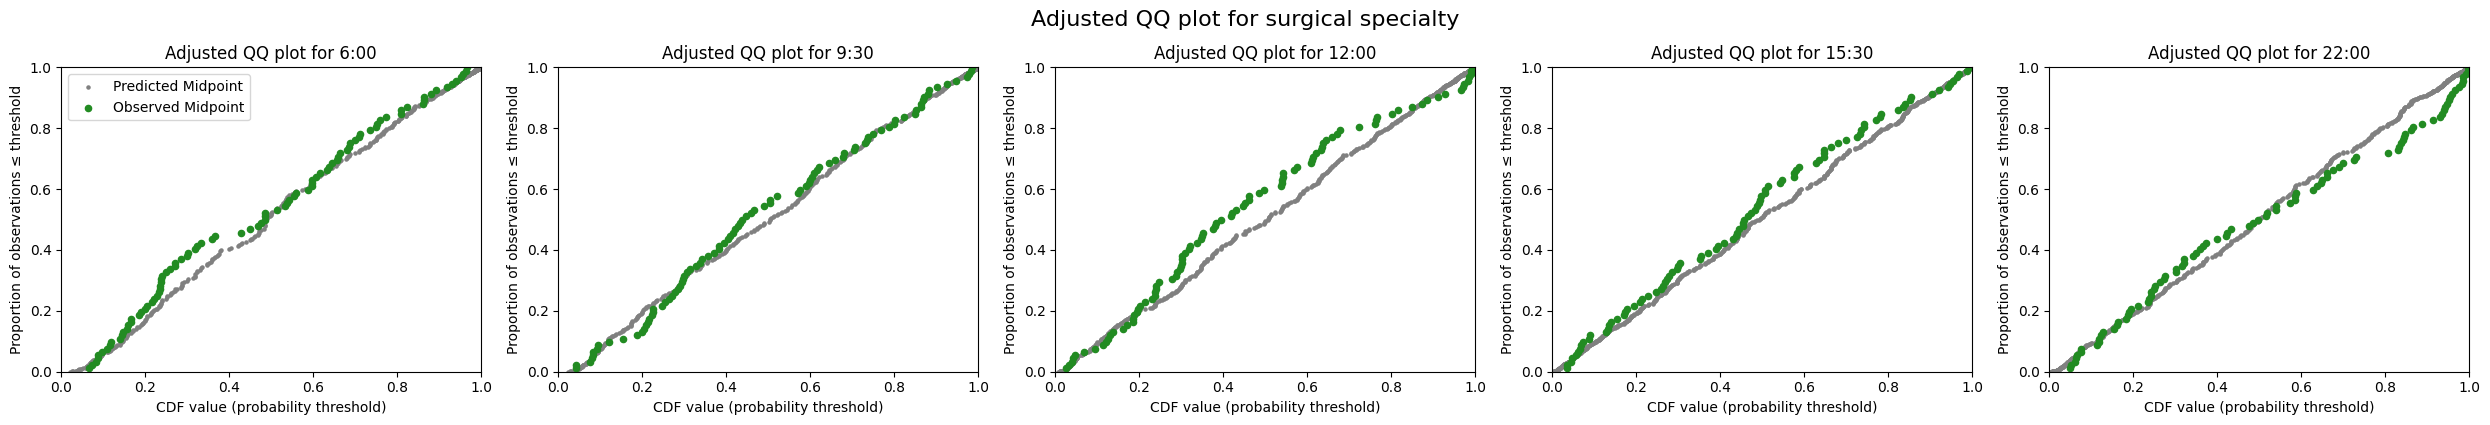

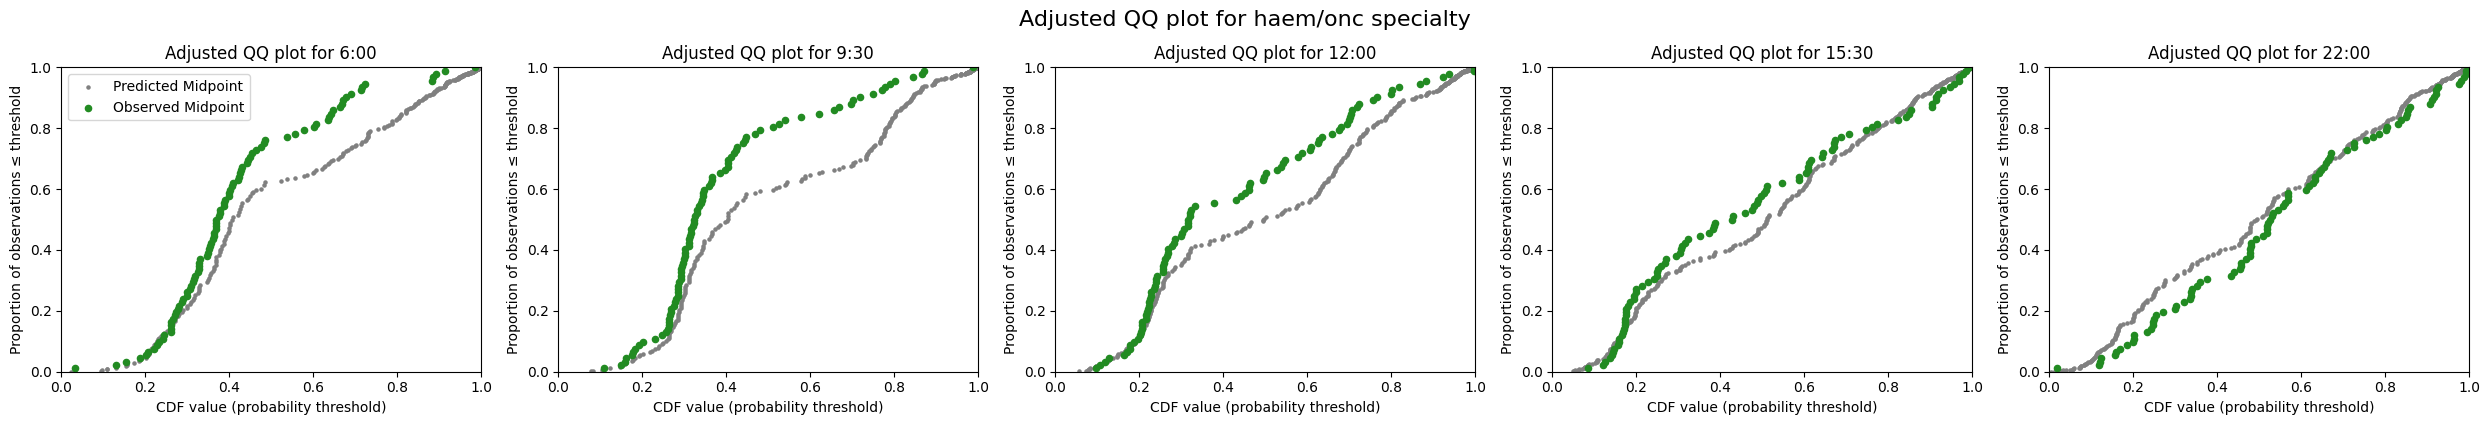

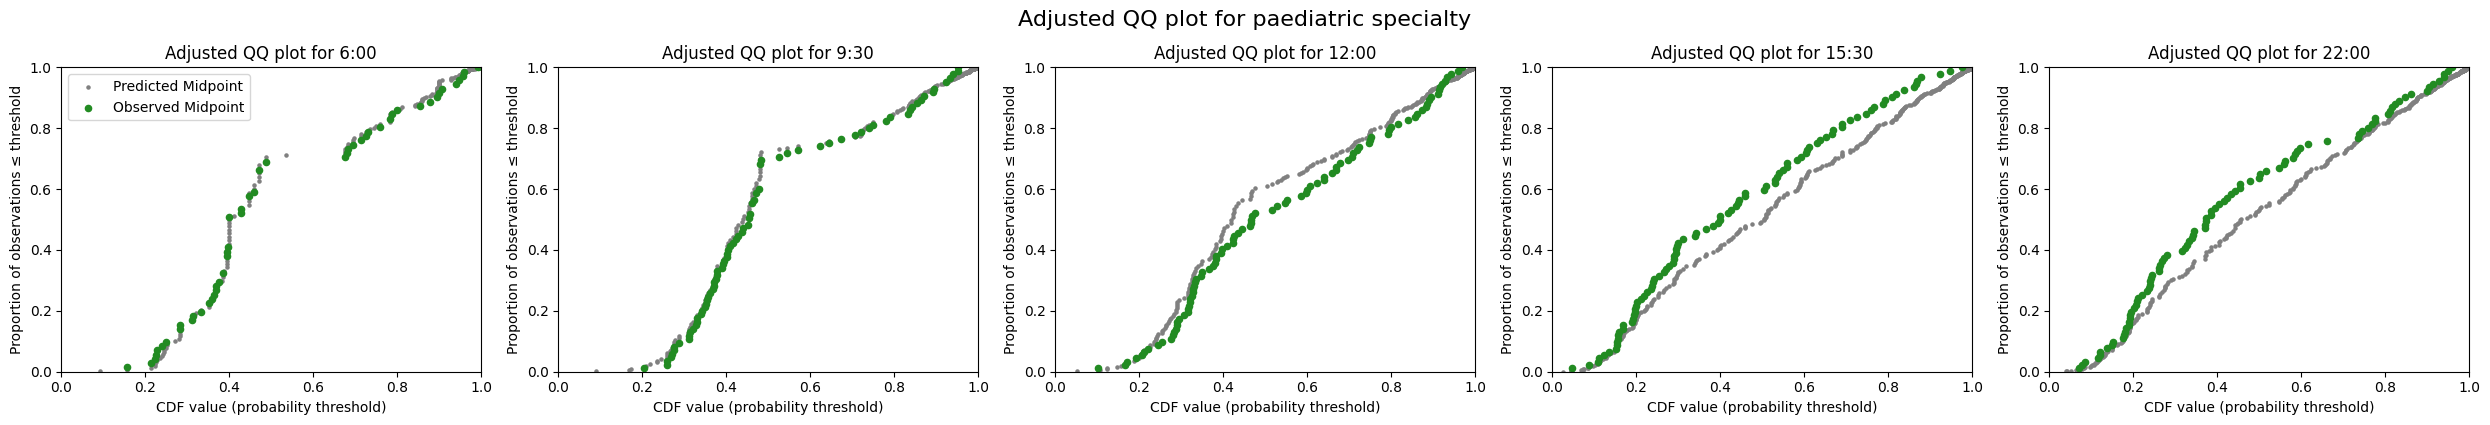

In [12]:
from patientflow.viz.adjusted_qq_plot import adjusted_qq_plot
specialties=['medical', 'surgical', 'haem/onc', 'paediatric']

for specialty in specialties:

    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all.items()}

    adjusted_qq_plot(ed_visits.prediction_time.unique(), 
            specialty_prob_dist,
            model_name="admissions",
            suptitle=f"Adjusted QQ plot for {specialty} specialty")

In medical specialties (which have the highest numbers of admissions, accounting for significant majority) the model performance is similar to that seen when not sub-divided by specialty. (See [a previous notebook](3b_Evaluate_group_snapshots.ipynb) for more on this.) The model underestimates beds needed for patients in the ED at 22:00 and overestimates at 12:00 and 15:30. 

The model is well calibrated for surgical specialties. 

For haematology/oncology the model under-predicts at most times of day. For paediatrics, the observed values track the model predictions very well at 06:00 and 09:30. The model is less well calibrated later in the day.  

### Comparing with a baseline prediction by specialty

The model predicting specialty of admission was trained on sequences of consults. A baseline would be to give each adult patient the same probability of admission to medical, surgical or haem/onc, based on past averages. To calculate past averages, I'll use the `inpatient_arrivals` since this includes all arrivals, with one row for each visits. (Note - the `ed_visits` dataset has multiple rows per visit; I could use this by including only admitted patients with their specialty, and dropping duplicate rows. )

In [65]:
baseline_probs = train_inpatient_arrivals_df[~(train_inpatient_arrivals_df.is_child) & 
                                             (train_inpatient_arrivals_df.specialty.isin(['medical', 'surgical', 'haem/onc']))]['specialty'].value_counts(normalize=True).to_dict()
baseline_probs['paediatric'] = 0

prob_dist_dict_all_baseline = get_specialty_probability_distributions_with_special_categories(
    test_visits_df=test_visits_df,
    spec_model=spec_model,      
    admissions_models=admissions_models,
    model_name=model_name,
    exclude_from_training_data=exclude_from_training_data,
    baseline_prob_dict=baseline_probs
)


Processing :(22, 0)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all snapshots in the test set

Processing :(15, 30)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all snapshots in the test set

Processing :(6, 0)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all 


Adjusted QQ plots for medical specialty


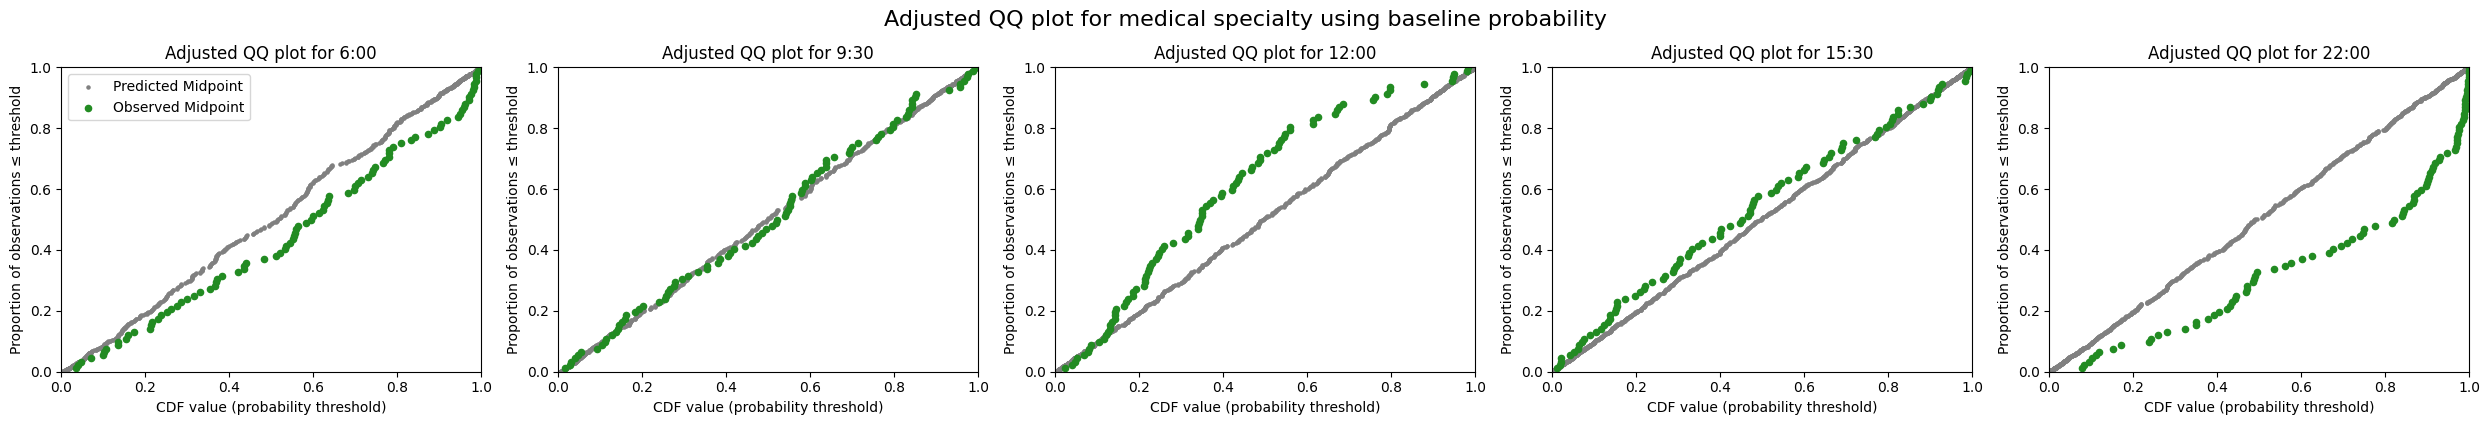

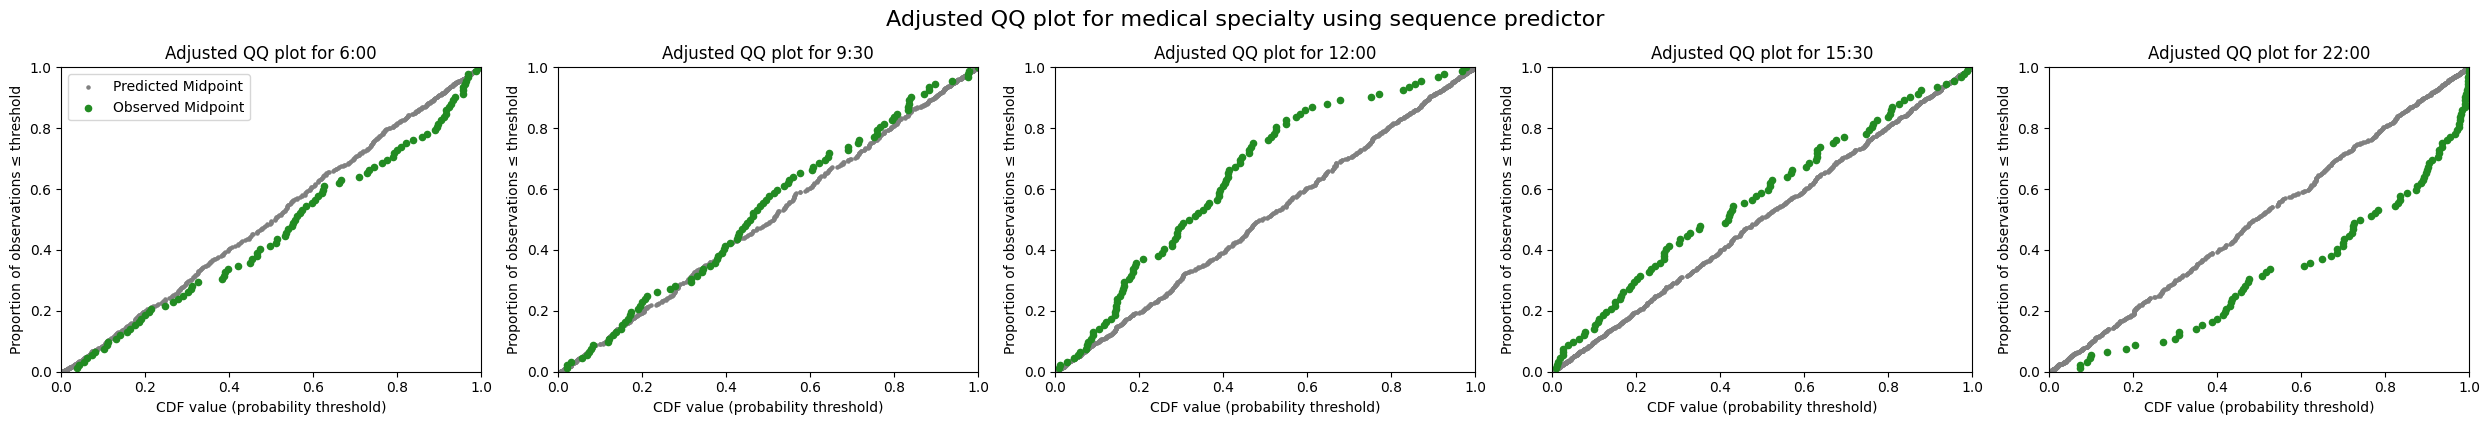


Adjusted QQ plots for surgical specialty


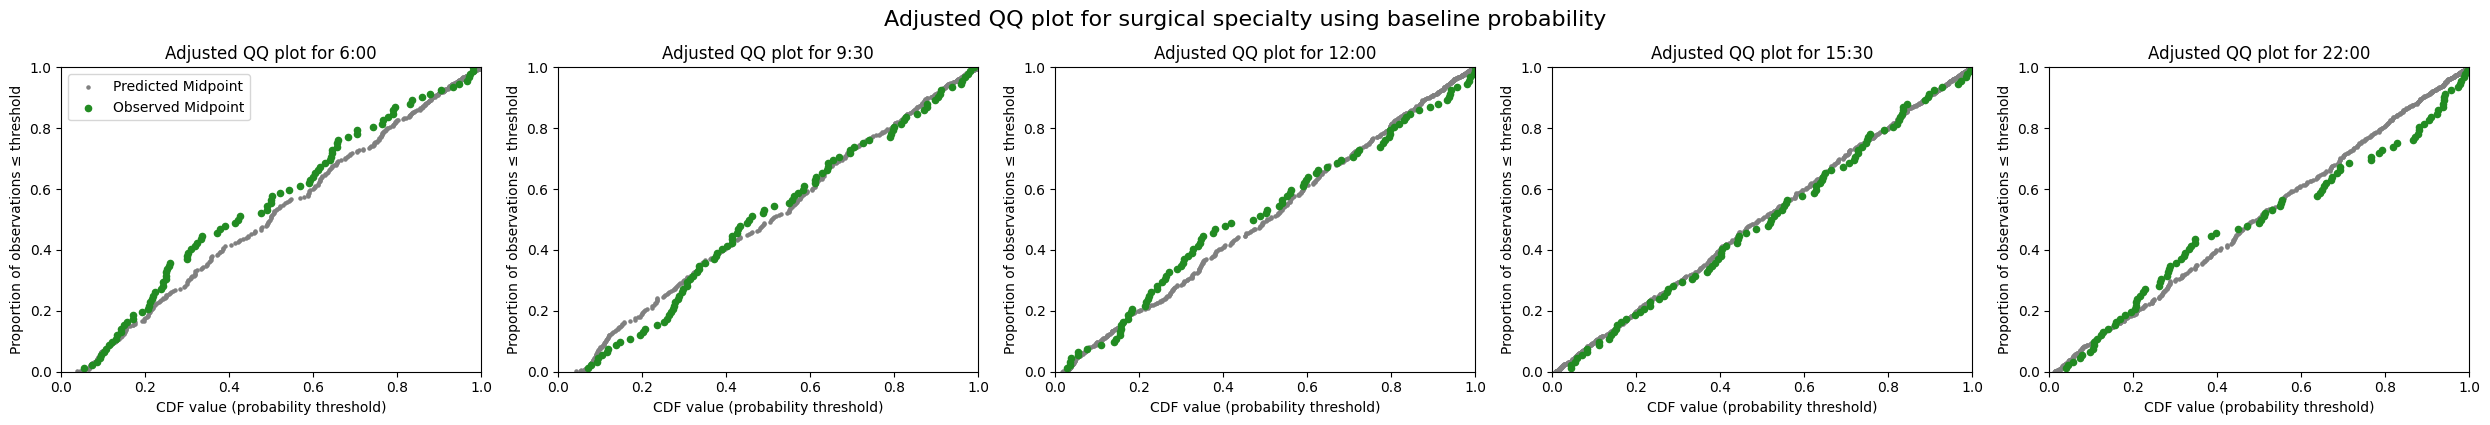

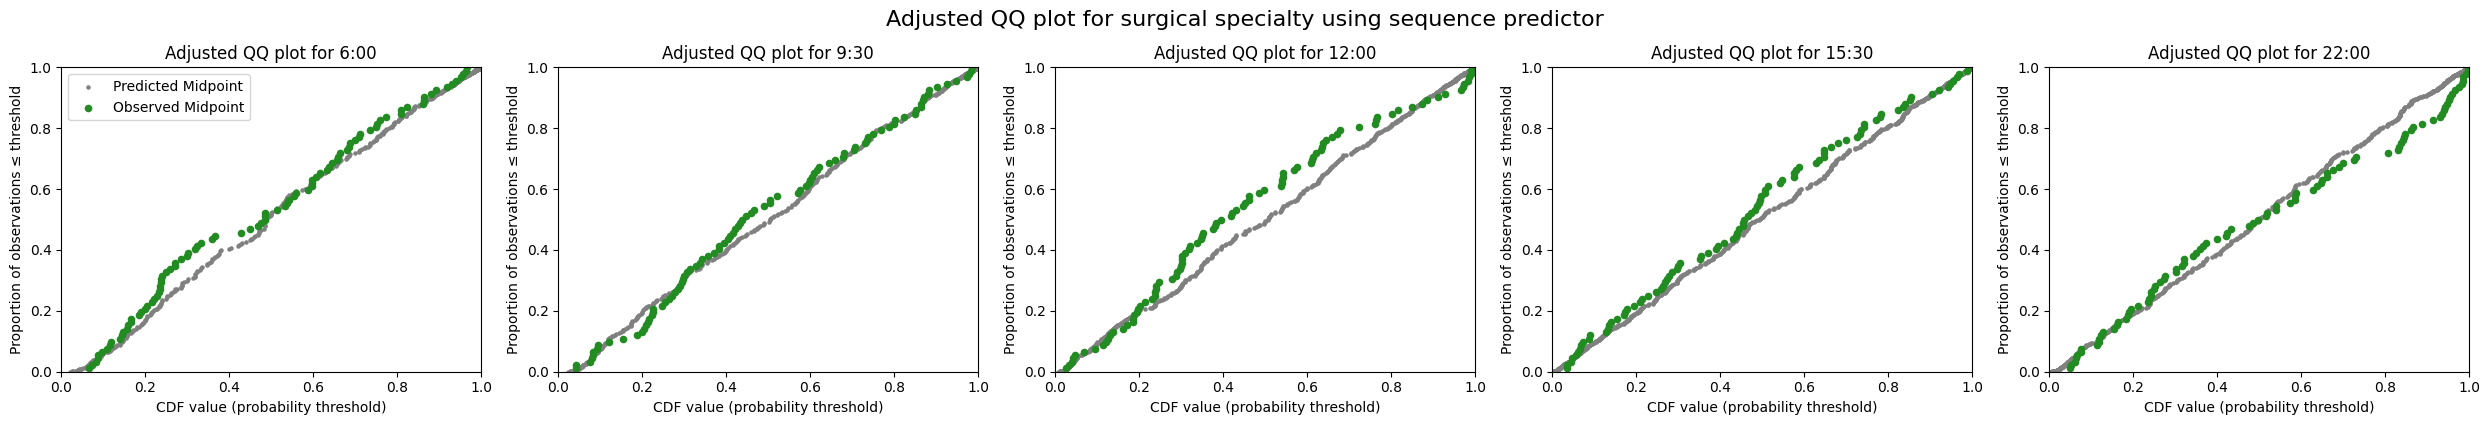


Adjusted QQ plots for haem/onc specialty


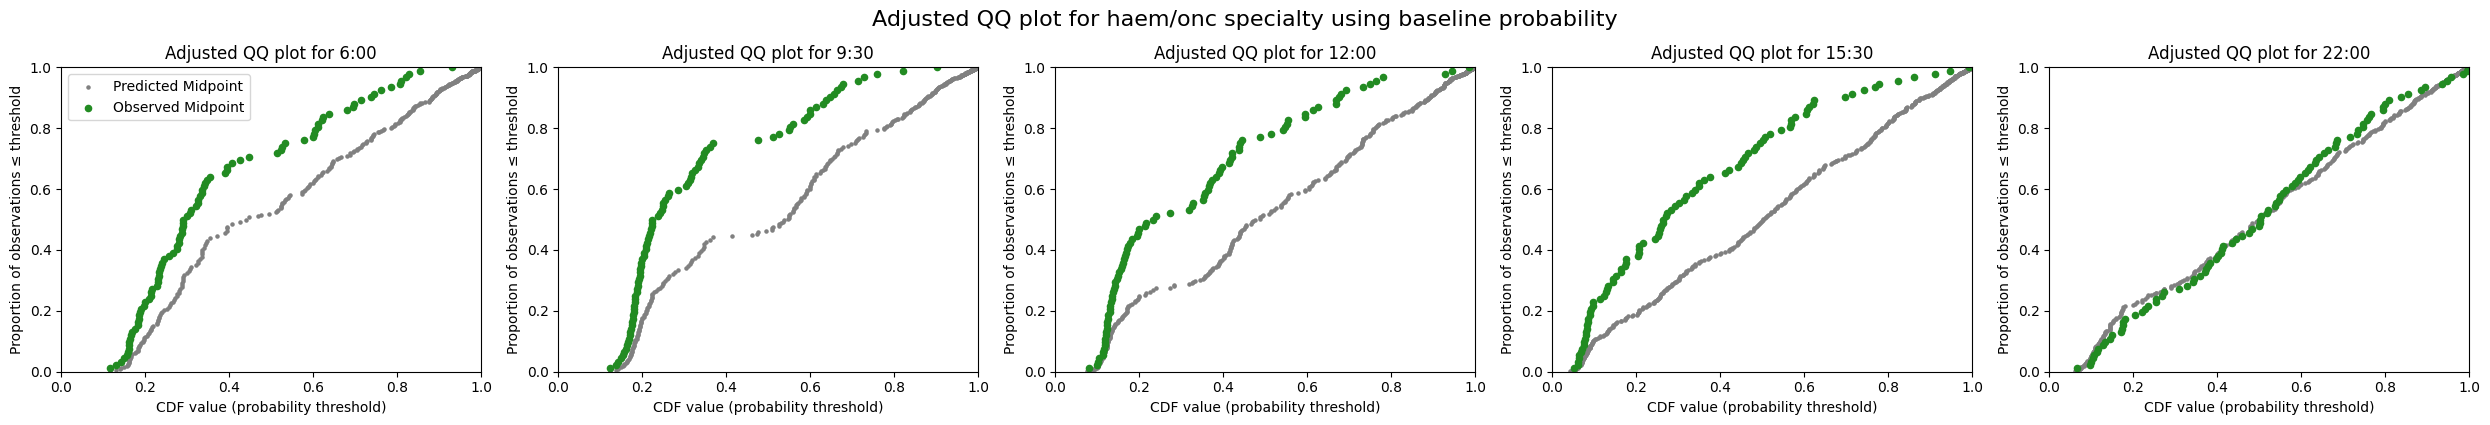

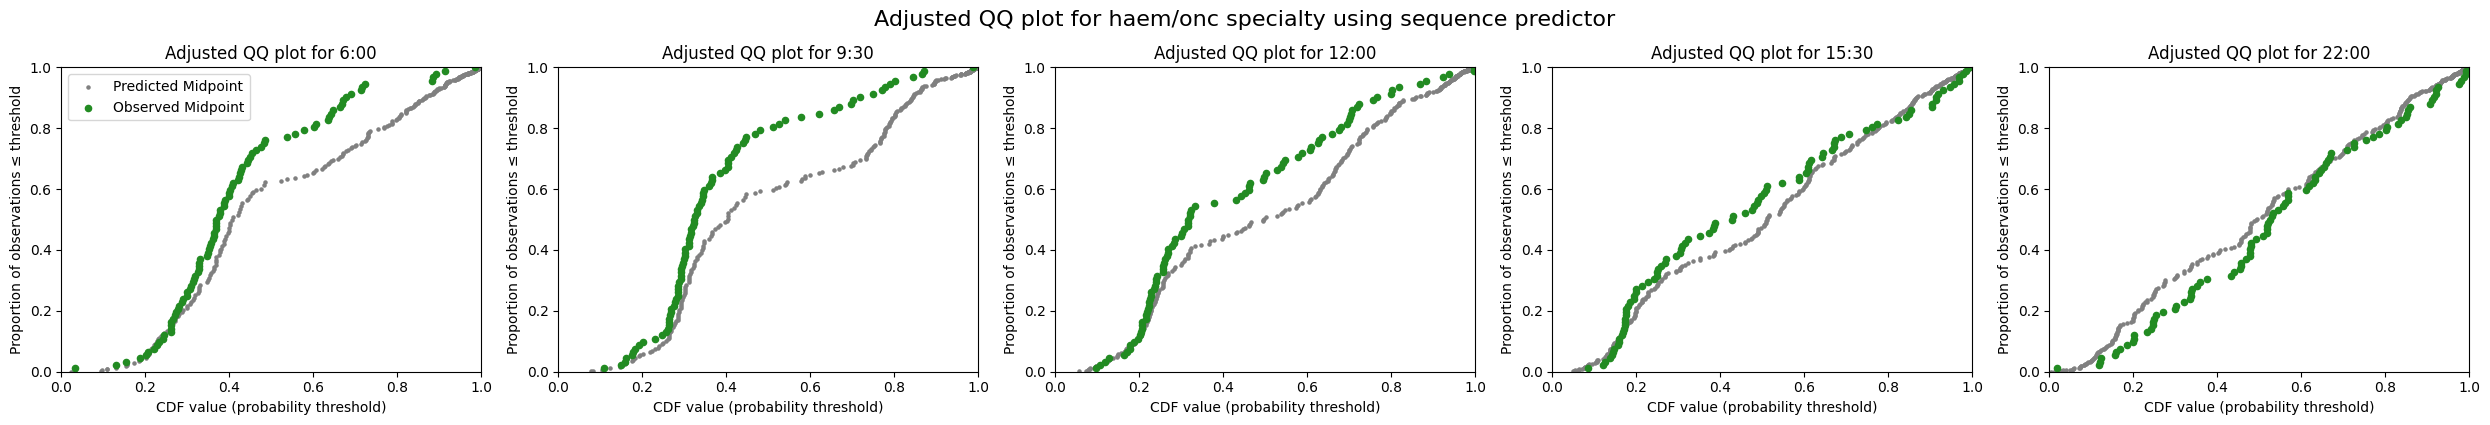

In [69]:
from patientflow.viz.adjusted_qq_plot import adjusted_qq_plot

for specialty in ['medical', 'surgical', 'haem/onc']:

    print(f'\nAdjusted QQ plots for {specialty} specialty')

    specialty_prob_dist_baseline = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all_baseline.items()}
    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all.items()}

    adjusted_qq_plot(ed_visits.prediction_time.unique(), 
        specialty_prob_dist_baseline,
        model_name="admissions",
        suptitle=f"Adjusted QQ plot for {specialty} specialty using baseline probability")
    
    adjusted_qq_plot(ed_visits.prediction_time.unique(), 
        specialty_prob_dist,
        model_name="admissions",
        suptitle=f"Adjusted QQ plot for {specialty} specialty using sequence predictor")

For each of the adult specialties, the plots above compare the baseline model (above) with a model using consult sequences (below). Particularly for haem/onc there is an improvement; the extent of over-predictino is reduced. 

## Evaluate predictions for patients yet-to-arrive to the ED

As the predictions for yet-to-arrive patients are aspirational, these cannot be directly compared with observed numbers of patients who arrived after the moment of prediction, and were admitted within the prediction window. Due to slower than target processing of patients through the ED, these future arrivals would have a smaller likelihood of being admitted within the window than suggested by the aspirational target. 

We can, however, compare the predictions based on arrival rates at the front door of ED, that were learned from the training set, against observed arrival rates at the front door during the test set. 

To illustrate, I start by plotting the cumulative arrivals of patients later admitted within a prediction window on one date. The blue line shows the cumulative number of arrivals. The orange lines shows the cumulative mean arrival rate.


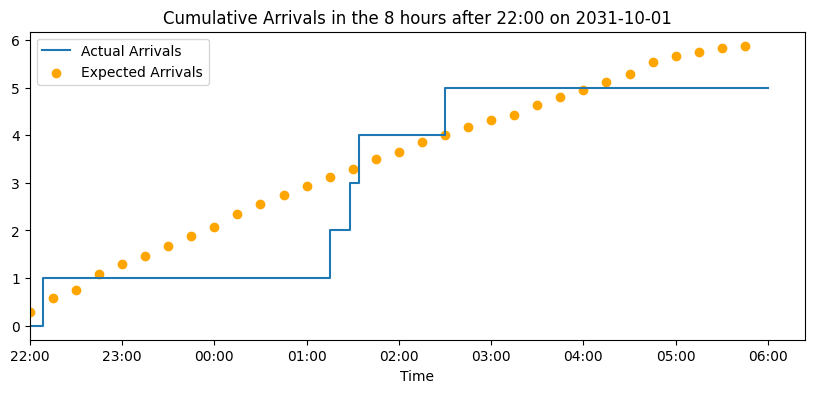

In [13]:
from patientflow.viz.arrival_comparison import plot_arrival_comparison
plot_arrival_comparison(test_inpatient_arrivals_df, (22,0), start_test_set, prediction_window, show_delta=False, yta_time_interval = 15)


# plt.show()

The chart below show the delta between the two lines

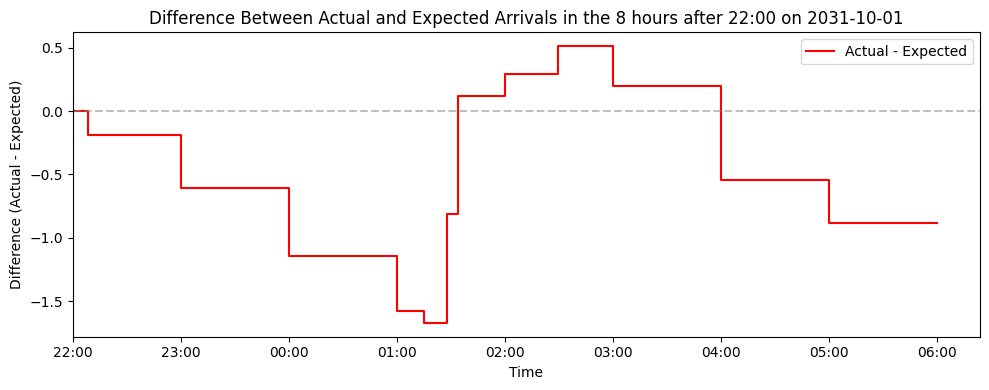

In [14]:
plot_arrival_comparison(test_inpatient_arrivals_df, (22,0), start_test_set, prediction_window, show_only_delta=True, yta_time_interval = 60)


The chart below shows multiple version of the delta for each date in the test set, for each prediction time, with the average delta shown in red. 

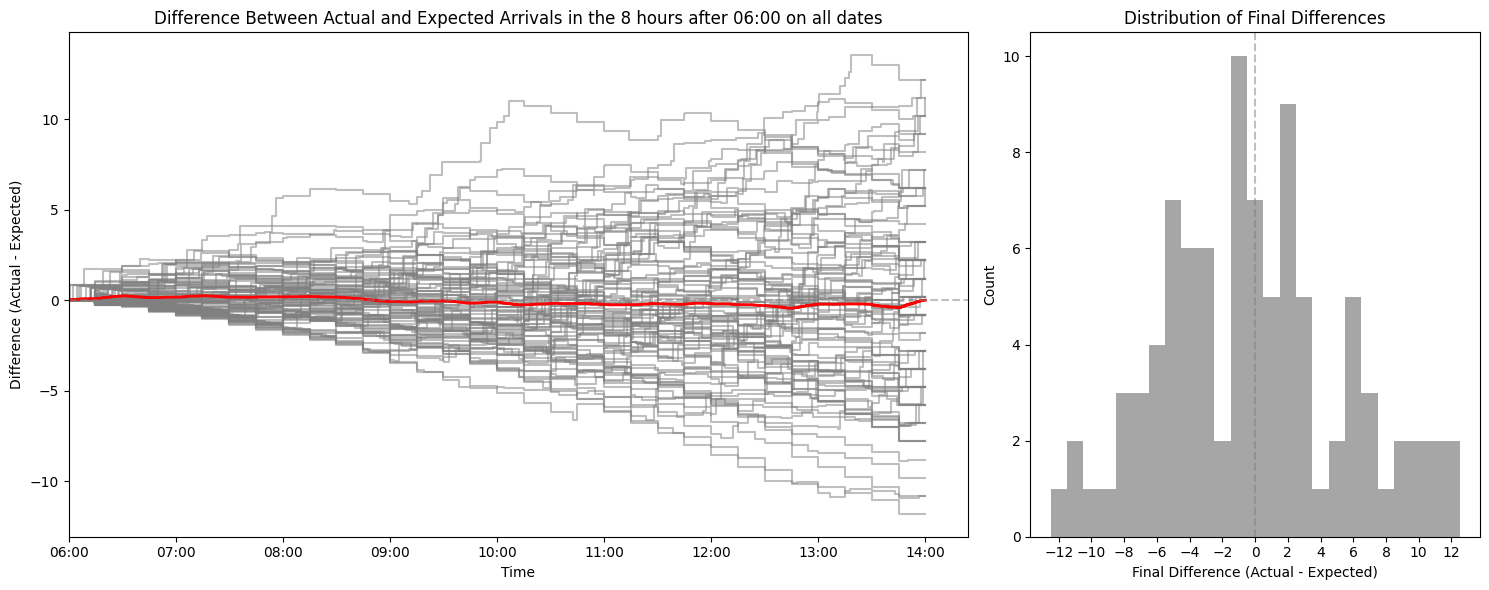

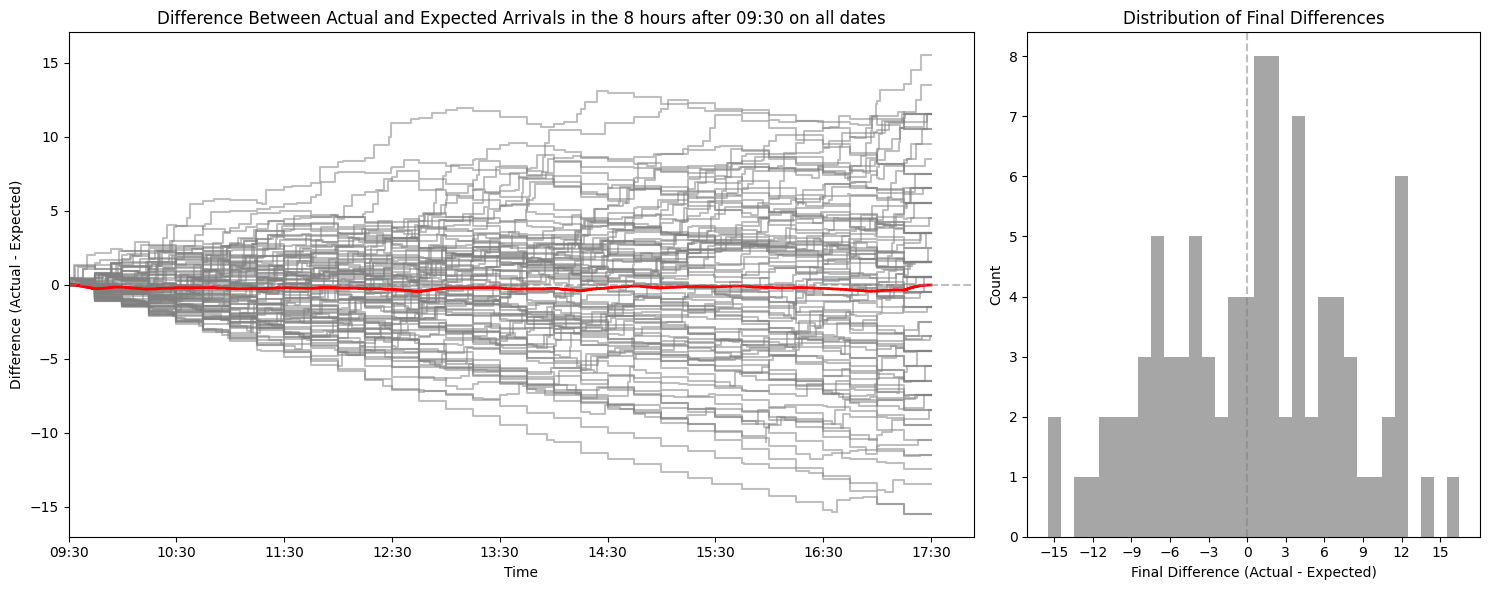

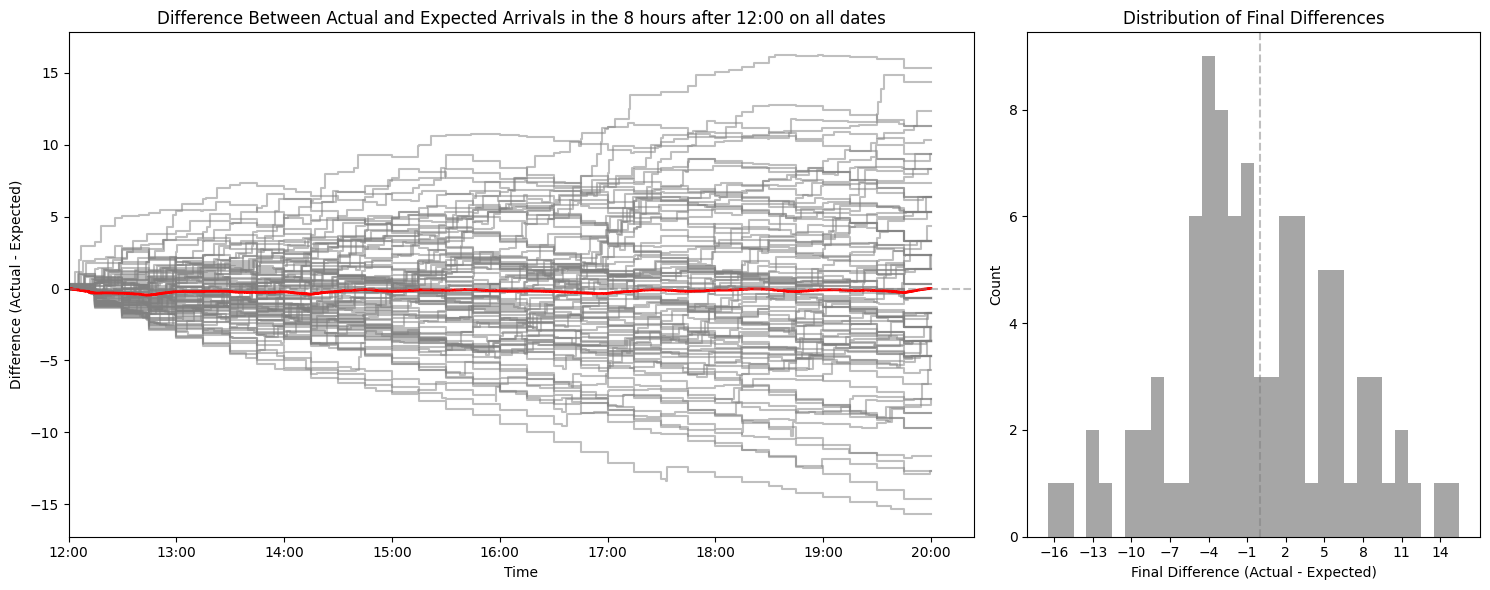

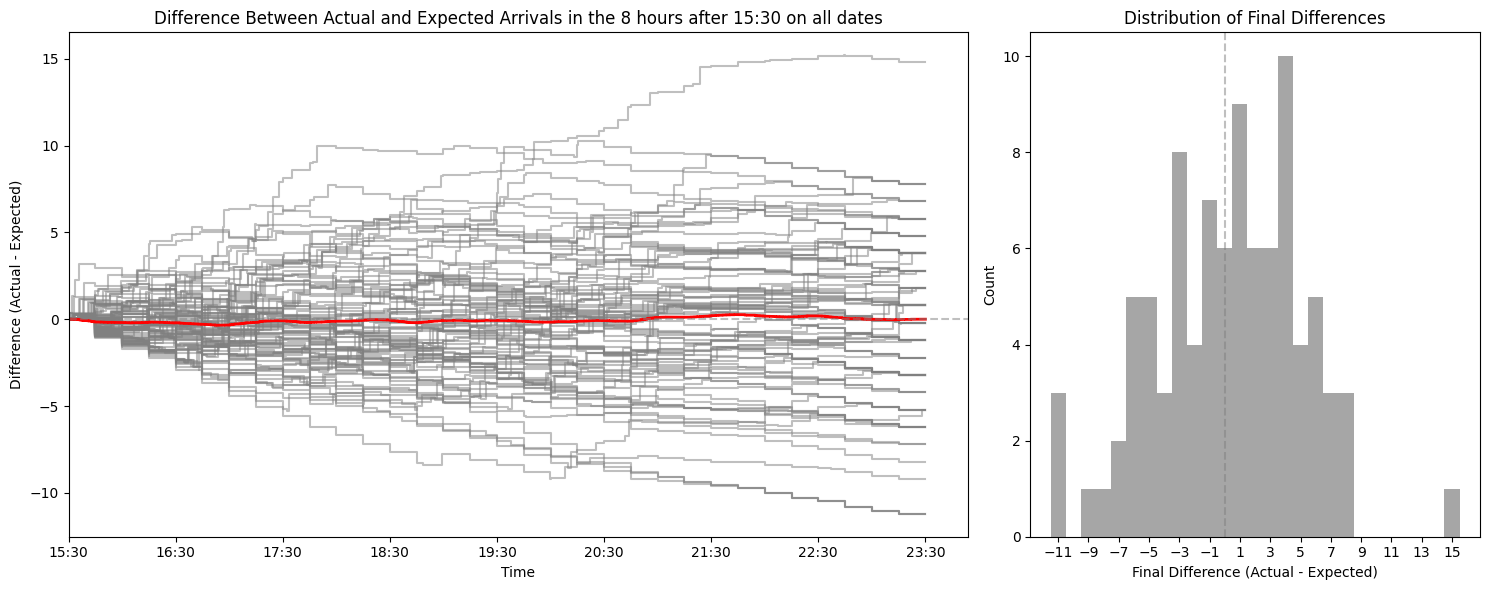

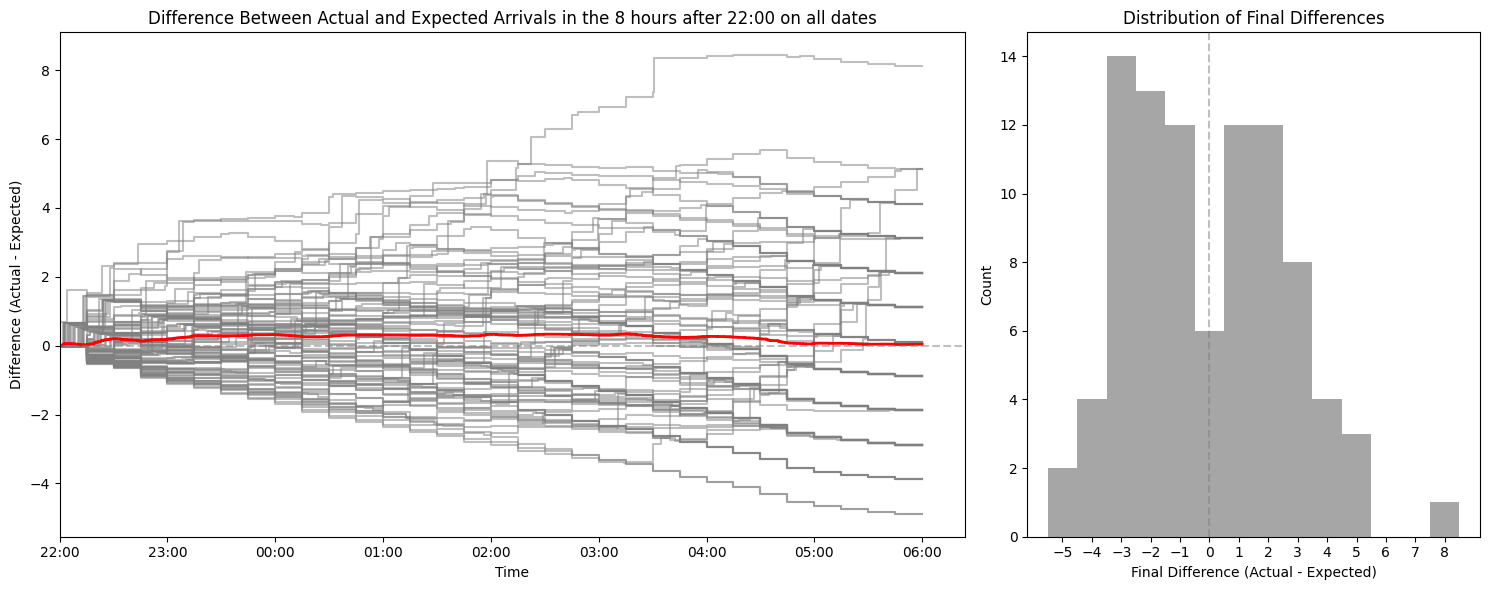

In [15]:
from patientflow.viz.arrival_comparison import plot_multiple_deltas
from datetime import timedelta


start_date = start_test_set
end_date = end_test_set
snapshot_dates = []

current_date = start_date
while current_date < end_date:
    snapshot_dates.append(current_date)
    current_date += timedelta(days=1)

        # Sort prediction times by converting to minutes since midnight
prediction_times_sorted = sorted(
    ed_visits.prediction_time.unique(),
    key=lambda x: x[0] * 60 + x[1],  # Convert (hour, minute) to minutes since midnight
)

for prediction_time in prediction_times_sorted:
    plot_multiple_deltas(test_inpatient_arrivals_df, prediction_time, snapshot_dates, prediction_window, yta_time_interval=15)

## Summary

In this notebook I have shown how to evaluate predicted bed counts for the patients in ED, by specialty, and for the patients yet-to-arrive. Both approaches required adjustments for the fact that the predicted distributions are aspirational. 

These models are based on a relatively small dataset (six months of training data, a one month validation set and a 3 month test set).  In the real-time application at UCLH, we use much more training data, and we also have the benefit of some additional features (such as age as a continuous variable) which improves model performance. 

Nonetheless, the models perform well on the relatively small datasets made available here. 